## Import libraries<a name="import"></a>

In [31]:
import os
import pyxdf  # xdf file importation
import matplotlib.pyplot as plt
import numpy as np

from my_functions import *
from my_filters import *

### Ensure that the root directory is the project directory
In some cases, the root directory may not be the project directory. This is usually the case when the notebook is run from a subdirectory of the project directory.

In [32]:
# if pwd is SRC  change to root
print("Current working directory: ", os.getcwd())
if os.path.basename(os.getcwd()) == "SRC":
    os.chdir("..")
print("Current working directory: ", os.getcwd())
print(os.path.basename(os.getcwd()))

Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Current working directory:  c:\Users\iWiss\Documents\GitHub\Stage_Signal_Physio
Stage_Signal_Physio


In [33]:
plt.close("all")  # close all figure windows

## Initialization

### Xdf file selection and loading (REARM data)

In [34]:
# Define the xdf file of interest
xdf_input_filename = "001_MolLud_20201112_1_c.xdf"
# xdf_input_filename="020_DesMar_20211129_1_c.xdf"

xdf_input_filepath = os.path.normpath("DAT/INPUT/"+xdf_input_filename)

In [35]:
# definition of the EEG channels' names
channels_dict = {"Channel_1": "C4",
                 "Channel_2": "FC2",
                 "Channel_3": "FC6",
                 "Channel_4": "CP2",
                 "Channel_5": "C3",
                 "Channel_6": "FC1",
                 "Channel_7": "FC5",
                 "Channel_8": "CP1"}

In [36]:
test0 = retrieve_stream_data_from_xdf(
    xdf_input_filepath=xdf_input_filepath, stream_type="EEG")
print(test0["infos"]["channels"]["names"])
print(test0["infos"]["channels"]["units"])

Accessing stream: 
Type: 'EEG' | Name: 'LSLOutletStreamName-EEG'
['Ch1', 'Ch2', 'Ch3', 'Ch4', 'Ch5', 'Ch6', 'Ch7', 'Ch8']
['microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts', 'microvolts']


## EEG

### EEG signal : Retrieve and shape time signals data

In [37]:
EEG_data = retrieve_stream_data_from_xdf(
    xdf_input_filepath=xdf_input_filepath, stream_type="EEG")

EEG_timestamps = EEG_data["data"]["timestamps"] - \
    EEG_data["data"]["timestamps"][0]
EEG_srate = EEG_data["infos"]["sample_rate"]["effective"]
EEG_units = np.unique(EEG_data["infos"]["channels"]["units"])[0]

EEG_amplitudes_centered = detrend_signals(EEG_data["data"]["time_series"])
EEG_amplitudes_rereferenced = rereference_signals(
    input_signals=EEG_amplitudes_centered)
EEG_amplitudes_centered_filtered, _, _ = filter_signal(input_signals=EEG_amplitudes_rereferenced,
                                                       sample_rate=EEG_srate, order=8, cutofffreq=(5, 100, 50))

Accessing stream: 
Type: 'EEG' | Name: 'LSLOutletStreamName-EEG'
input_signals shape:
 (221938, 8)
input_signals mean per signal:
 [27897.195 26144.139 28026.402 35319.527 31324.672 24827.713 32372.799
 29788.95 ]
input_signals shape:(221938, 8)
input_signals whole mean:13.818697929382324
mean_vector shape: ()
LOW_CUTOFF_FREQ_THEORETICAL=5,HIGH_CU-TOFF_FREQ_THEORETICAL=100
LOW_CUTOFF_FREQ_CORRECTED=4.732,HIGH_CUTOFF_FREQ_CORRECTED=104.203
NOTCH_CUTOFF_FREQ=50
Filtered signal shape: (221938, 8)


### Mouse markers : Retrieve and shape data

In [38]:
mouse_marker_times_labels = create_marker_times_labels_array2(
    xdf_input_filepath=xdf_input_filepath)
# make times start in reference to the first EEG timestamp instead of unix epoch.
mouse_marker_times_labels[:, 0] -= EEG_data["data"]["timestamps"][0]

Accessing stream: 
Type: 'Markers' | Name: 'MouseToNIC'


### Epoch EEG Data

#### Define Epoch limits in reference to events

In [39]:
epoch_limits = (0, 4)

#### Epoch EEG signals

In [40]:
# epoch EEG signals
nearest_markers_array = nearest_timestamps_array_finder(
    signal_times_stamps=EEG_timestamps, markers=mouse_marker_times_labels)
EEG_signals_epoched = extract_data_epochs_from_all_signals(signals=EEG_amplitudes_centered_filtered, sample_rate=EEG_srate, markers_labels_times=nearest_markers_array,
                                                           select_events=(111, 100), epoch_limits=epoch_limits)

MARKERS LEN: 12
221938
Epoch limits relative to events (in sec): start: 0s - end: 4s
Epoch limits relative to events (in samples): n_points_before_marker: 0.0 - n_points_after_marker: 1999.990908174066
Event type : 111 ------------ epochs :
first_seg_coord: 13659 - second_seg_coord: 15658
first_seg_coord: 33660 - second_seg_coord: 35659
first_seg_coord: 53662 - second_seg_coord: 55661
first_seg_coord: 82834 - second_seg_coord: 84833
first_seg_coord: 102836 - second_seg_coord: 104835
first_seg_coord: 122837 - second_seg_coord: 124836
signal_segments shape: (2000, 6)
time_segments shape: (2000, 6)
Event type : 100 ------------ epochs :
first_seg_coord: 23660 - second_seg_coord: 25659
first_seg_coord: 43661 - second_seg_coord: 45660
first_seg_coord: 63663 - second_seg_coord: 65662
first_seg_coord: 92835 - second_seg_coord: 94834
first_seg_coord: 112837 - second_seg_coord: 114836
first_seg_coord: 132838 - second_seg_coord: 134837
signal_segments shape: (2000, 6)
time_segments shape: (2000,

##### Plot an EEG Epoch

In [41]:
epoch_num=1
epoch_index=epoch_num-1

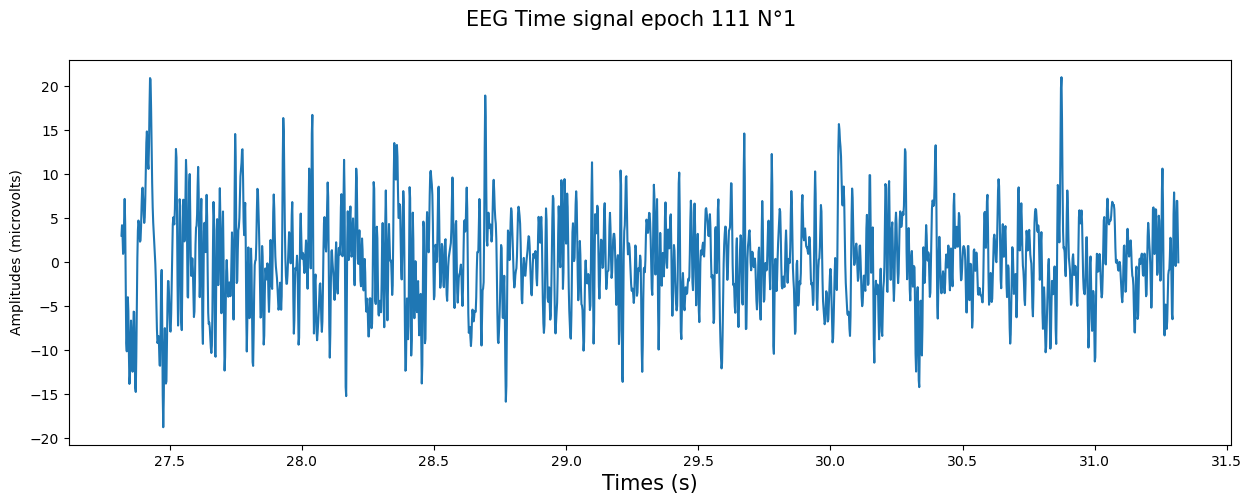

In [42]:
# Plot
figure, axis = plt.subplots(1, figsize=(15, 5))
figure.suptitle("EEG Time signal epoch 111 N°1",fontsize=15)
axis.set_xlabel("Times (s)",fontsize=15)
axis.set_ylabel(f"Amplitudes ({EEG_units})")
axis.plot(EEG_signals_epoched["Channel_1"]["Epochs"]["time_signals"]["label_111"]["time_segments"][:,epoch_index],
          EEG_signals_epoched["Channel_1"]["Epochs"]["time_signals"]["label_111"]["signal_segments"][:, epoch_index])

#### Compute the PSD of all EEG epochs (for each signal)

In [43]:
EEG_signals_epochs_psds = compute_psds_for_each_epoch_all_signals(
    input_dict=EEG_signals_epoched, sample_rate=EEG_srate, nfft=None)

segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
segments shapes to psd - (2000, 6)
nfft: None
nfft: None
nfft: None
nfft: None
nfft: None
n

##### Plot an EEG Epoch and its PSD

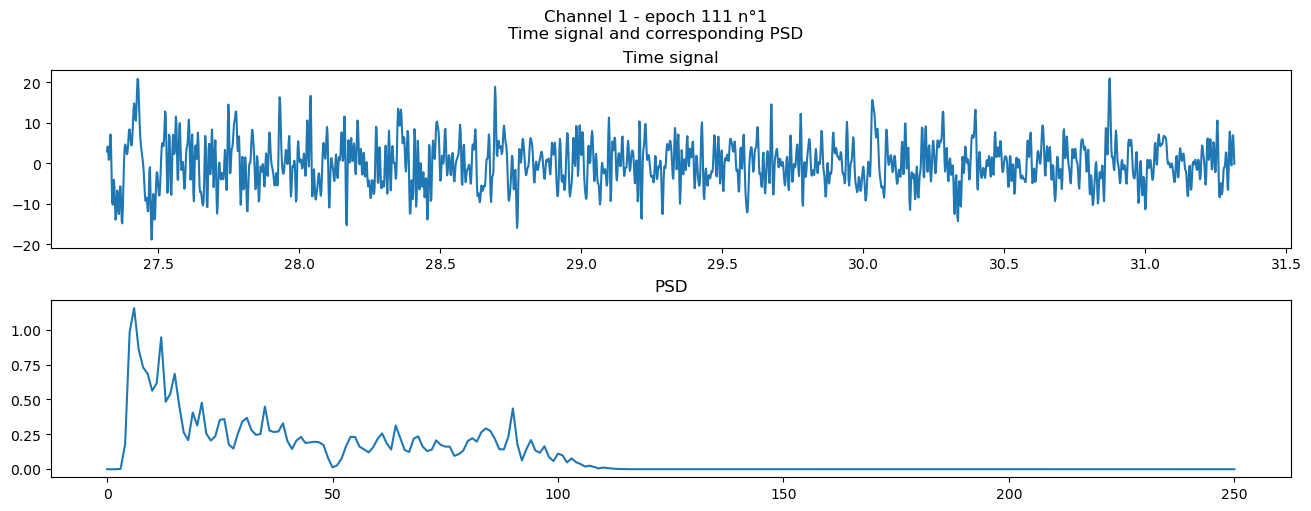

In [44]:
# Plot
figure, axis = plt.subplots(2, layout="constrained", figsize=(13, 5))
figure.suptitle("Channel 1 - epoch 111 n°1\nTime signal and corresponding PSD")
axis[0].set_title("Time signal")
axis[0].plot(EEG_signals_epoched["Channel_1"]["Epochs"]["time_signals"]["label_111"]["time_segments"][:, epoch_index],
             EEG_signals_epoched["Channel_1"]["Epochs"]["time_signals"]["label_111"]["signal_segments"][:, epoch_index])
axis[1].set_title("PSD")
axis[1].plot(EEG_signals_epochs_psds["Channel_1"]["Epochs"]["PSDs"]["label_111"]["PSD_frequencies"][:, epoch_index],
             EEG_signals_epochs_psds["Channel_1"]["Epochs"]["PSDs"]["label_111"]["PSD_magnitudes"][:, epoch_index])

## Mouse mocap : Retrieve and shape data

In [45]:
mouse_mocap_data = retrieve_stream_data_from_xdf(
    xdf_input_filepath=xdf_input_filepath, stream_type="MoCap", stream_name="Mouse")

mouse_mocap_positions_units = np.unique(
    mouse_mocap_data["infos"]["channels"]["units"][0:2])[0]
mouse_mocap_sample_rate = mouse_mocap_data["infos"]["sample_rate"]["effective"]
# make times start relative to the first EEG timestamp instead of unix epoch.
mouse_mocap_times = mouse_mocap_data["data"]["timestamps"] - \
    EEG_data["data"]["timestamps"][0]
# select only x and y position data
mouse_mocap_positions_xy = mouse_mocap_data["data"]["time_series"][:, 0:2]

Accessing stream: 
Type: 'MoCap' | Name: 'Mouse'


### Plot mouse X,Y positions

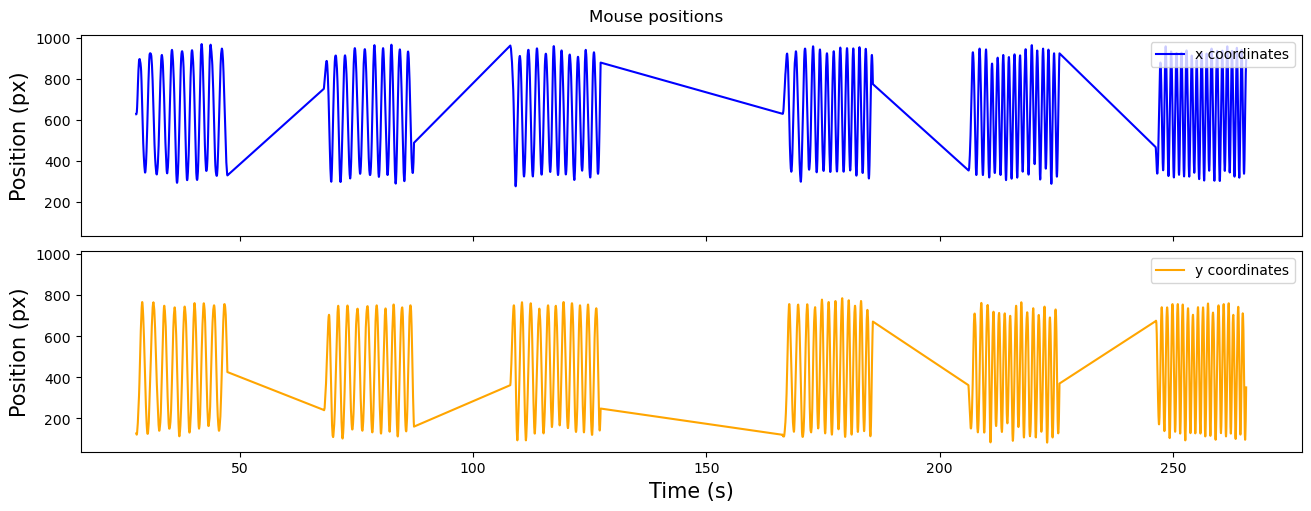

In [46]:
# Plot
figure, axis = plt.subplots(
    2, sharex=True, sharey=True, layout="constrained", figsize=(13, 5))
figure.suptitle("Mouse positions")

axis[0].plot(mouse_mocap_times, mouse_mocap_positions_xy[:, 0],
             label="x coordinates", color="b")
axis[0].set_ylabel("Position (px)",fontsize=15)
axis[0].legend(loc="upper right")

axis[1].plot(mouse_mocap_times, mouse_mocap_positions_xy[:, 1],
             label="y coordinates", color="orange")
axis[1].set_ylabel("Position (px)",fontsize=15)
axis[1].set_xlabel("Time (s)",fontsize=15)
axis[1].legend(loc="upper right")

### Compute mouse tangential speeds

In [47]:
mouse_tangential_speeds = compute_tangential_speed(coordinates=mouse_mocap_positions_xy,
                                              sample_rate=mouse_mocap_sample_rate)

mouse_tangential_speeds_threshold = 0.05*np.max(mouse_tangential_speeds)
print(
    f"mouse_mocap_speed_threshold = {mouse_tangential_speeds_threshold} ({mouse_mocap_positions_units}/s) ")

print(f"vt_max= {np.max(mouse_tangential_speeds)} ({mouse_mocap_positions_units}/s)")
print(f"vt_min= {np.min(mouse_tangential_speeds)} ({mouse_mocap_positions_units}/s)")
print(
    f"vt_moy= {np.mean(mouse_tangential_speeds)} ({mouse_mocap_positions_units}/s)")

mouse_mocap_speed_threshold = 3013.5616374589035 (pixels/s) 
vt_max= 60271.23274917807 (pixels/s)
vt_min= 93.92532860411228 (pixels/s)
vt_moy= 1270.3016690899083 (pixels/s)


#### Plot mouse tangential speeds

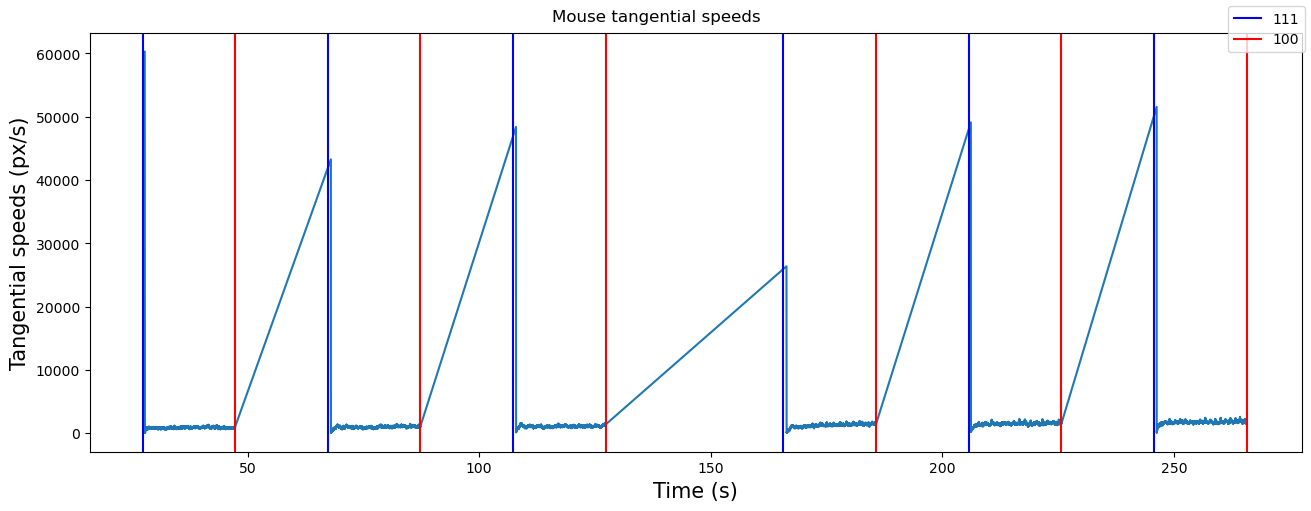

In [48]:
figure, axis = plt.subplots(layout="constrained",figsize=(13,5))
figure.suptitle("Mouse tangential speeds")
axis.plot(mouse_mocap_times,mouse_tangential_speeds)
axis.set_xlabel("Time (s)",fontsize=15)
axis.set_ylabel("Tangential speeds (px/s)",fontsize=15)
show_markers2(plot_type=axis,markers_times_array=mouse_marker_times_labels)
figure.legend()

Note: The signal is discontinuous leading to vertical peaks and diagonal lines. The vertical peaks are due to signal discontinuity and the horizonal parts of the signal are the real tangential speeds. Times pass from 47.3s to 67.3 etc;

## EEG accelerometer

### EEG accelerometer : Retrieve and shape data

In [49]:
eeg_accelerometer_data = retrieve_stream_data_from_xdf(
    xdf_input_filepath=xdf_input_filepath, stream_type="Accelerometer")

eeg_accelerometer_units = np.unique(
    eeg_accelerometer_data["infos"]["channels"]["units"])[0]
eeg_accelerometer_sample_rate = eeg_accelerometer_data["infos"]["sample_rate"]["effective"]
# make times start relative to the first EEG timestamp instead of unix epoch.
eeg_accelerometer_times = eeg_accelerometer_data["data"]["timestamps"] - \
    EEG_data["data"]["timestamps"][0]
eeg_accelerometer_xyz = eeg_accelerometer_data["data"]["time_series"]

Stream 9: Calculated effective sampling rate 499.9721 Hz is different from specified rate 100.0000 Hz.


Accessing stream: 
Type: 'Accelerometer' | Name: 'LSLOutletStreamName-Accelerometer'


### Plot EEG accelerations of all 3 axis

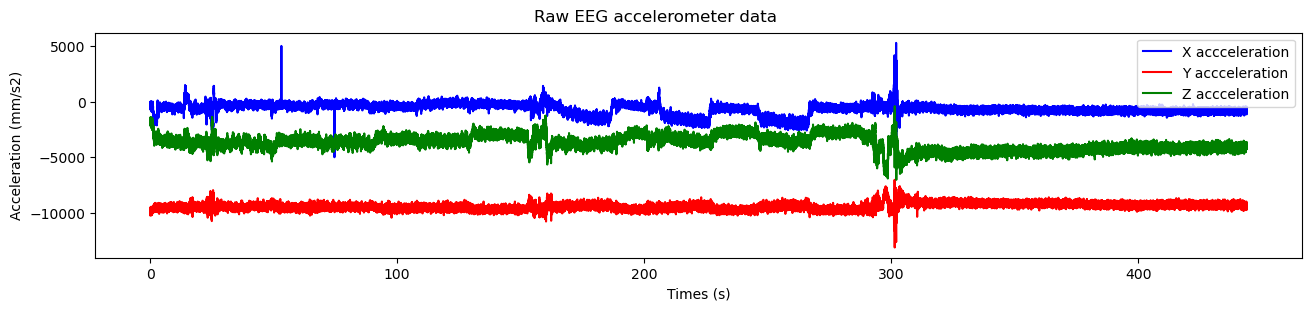

In [50]:
figure, axis = plt.subplots(1, layout="constrained", figsize=(13, 3))
figure.suptitle("Raw EEG accelerometer data")

axis.plot(eeg_accelerometer_times,
          eeg_accelerometer_xyz[:, 0], label="X accceleration", color="b")
axis.plot(eeg_accelerometer_times,
          eeg_accelerometer_xyz[:, 1], label="Y accceleration", color="r")
axis.plot(eeg_accelerometer_times,
          eeg_accelerometer_xyz[:, 2], label="Z accceleration", color="g")

axis.set_ylabel(f"Acceleration ({eeg_accelerometer_units})")
axis.set_xlabel(f"Times (s)")

axis.legend(loc="upper right")

### Compute EEG accelerations norm

In [51]:
eeg_accelerometer_norm = compute_total_acceleration(
    accelerations_array=eeg_accelerometer_xyz)

eeg_enmo = eeg_accelerometer_norm= eeg_accelerometer_norm-9806.65

#### Plot EEG accelerations norm

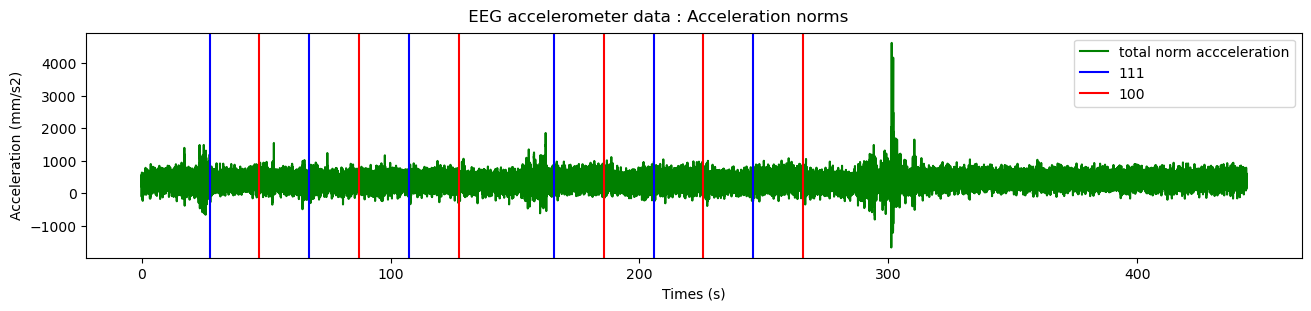

In [52]:
figure, axis = plt.subplots(1, layout="constrained", figsize=(13, 3))
figure.suptitle(" EEG accelerometer data : Acceleration norms")

axis.plot(eeg_accelerometer_times, eeg_accelerometer_norm,
          label="total norm accceleration", color="g")
show_markers2(plot_type=axis, markers_times_array=mouse_marker_times_labels)

axis.set_ylabel(f"Acceleration ({eeg_accelerometer_units})")
axis.set_xlabel(f"Times (s)")

axis.legend(loc="upper right")

#### Filter EEG accelerations norm

In [53]:
eeg_accelerometer_norm_filtered, freqs, h5 = low_pass_filter(input_signal=eeg_accelerometer_norm, sample_rate=eeg_accelerometer_sample_rate,
                                                             cutoff_freq=1, filter_order=2)
#eeg_accelerometer_norm_filtered = eeg_accelerometer_norm_filtered-9806.65

##### Plot Filtered EEG accelerations norm

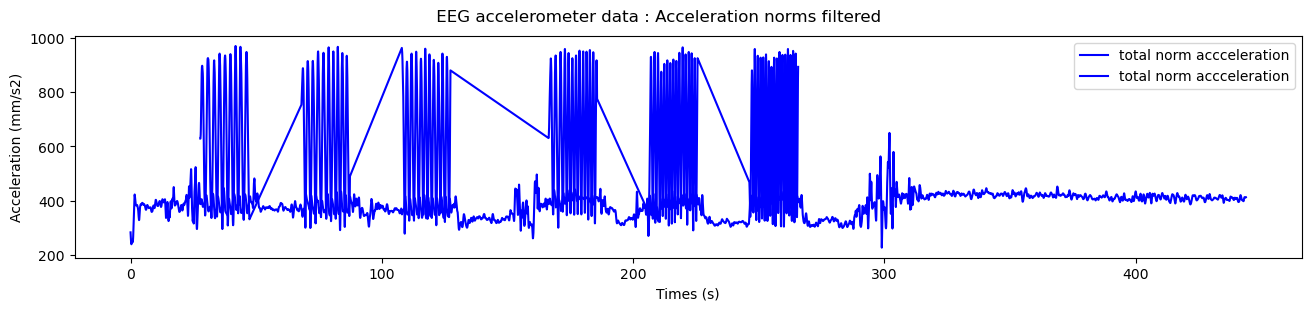

In [54]:
# Plot
figure, axis = plt.subplots(1, layout="constrained", figsize=(13, 3))
figure.suptitle(" EEG accelerometer data : Acceleration norms filtered")

axis.plot(eeg_accelerometer_times, eeg_accelerometer_norm_filtered,
          label="total norm accceleration", color="b")
axis.plot(mouse_mocap_times,
          mouse_mocap_positions_xy[:, 0], label="total norm accceleration", color="b")


axis.set_ylabel(f"Acceleration ({eeg_accelerometer_units})")
axis.set_xlabel(f"Times (s)")

axis.legend(loc="upper right")

#### Epoch EEG accelerometer data

In [55]:
# epoch EEG  accelerometer signals

nearest_markers_array_acc_eeg = nearest_timestamps_array_finder(
    signal_times_stamps=eeg_accelerometer_times, markers=mouse_marker_times_labels)

eeg_accelerometer_norm_filtered_epoched = extract_data_epochs(signal=eeg_accelerometer_norm_filtered, sample_rate=eeg_accelerometer_sample_rate,
                                                              markers_labels_times=nearest_markers_array_acc_eeg, select_events=(111, 100), epoch_limits=epoch_limits)


MARKERS LEN: 12
Epoch limits relative to events (in sec): start: 0s - end: 4s
Epoch limits relative to events (in samples): n_points_before_marker: 0.0 - n_points_after_marker: 1999.888572084638
Event type : 111 ------------ epochs :
first_seg_coord: 13659 - second_seg_coord: 15658
first_seg_coord: 33660 - second_seg_coord: 35659
first_seg_coord: 53660 - second_seg_coord: 55659
first_seg_coord: 82832 - second_seg_coord: 84831
first_seg_coord: 102833 - second_seg_coord: 104832
first_seg_coord: 122834 - second_seg_coord: 124833
signal_segments shape: (2000, 6)
time_segments shape: (2000, 6)
Event type : 100 ------------ epochs :
first_seg_coord: 23660 - second_seg_coord: 25659
first_seg_coord: 43660 - second_seg_coord: 45659
first_seg_coord: 63661 - second_seg_coord: 65660
first_seg_coord: 92833 - second_seg_coord: 94832
first_seg_coord: 112834 - second_seg_coord: 114833
first_seg_coord: 132834 - second_seg_coord: 134833
signal_segments shape: (2000, 6)
time_segments shape: (2000, 6)


### Plot EEG epoched time signal and its psd + corresponding accelerometer data

#### select EEG channels to plot

In [56]:
# Select EEG channel
print(channels_dict)

# selected_channel_num=[1,5]
selected_channel_num = np.arange(1, 9, 1).tolist()

{'Channel_1': 'C4', 'Channel_2': 'FC2', 'Channel_3': 'FC6', 'Channel_4': 'CP2', 'Channel_5': 'C3', 'Channel_6': 'FC1', 'Channel_7': 'FC5', 'Channel_8': 'CP1'}


#### Generate a list of figures for each electrode and epoch

C:\Users\iWiss\AppData\Local\Temp\ipykernel_5260\4288249387.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  figure, axis = plt.subplots(3, figsize=(13, 8))


Error in callback <function _draw_all_if_interactive at 0x000001AD637658A0> (for post_execute):


KeyboardInterrupt: 

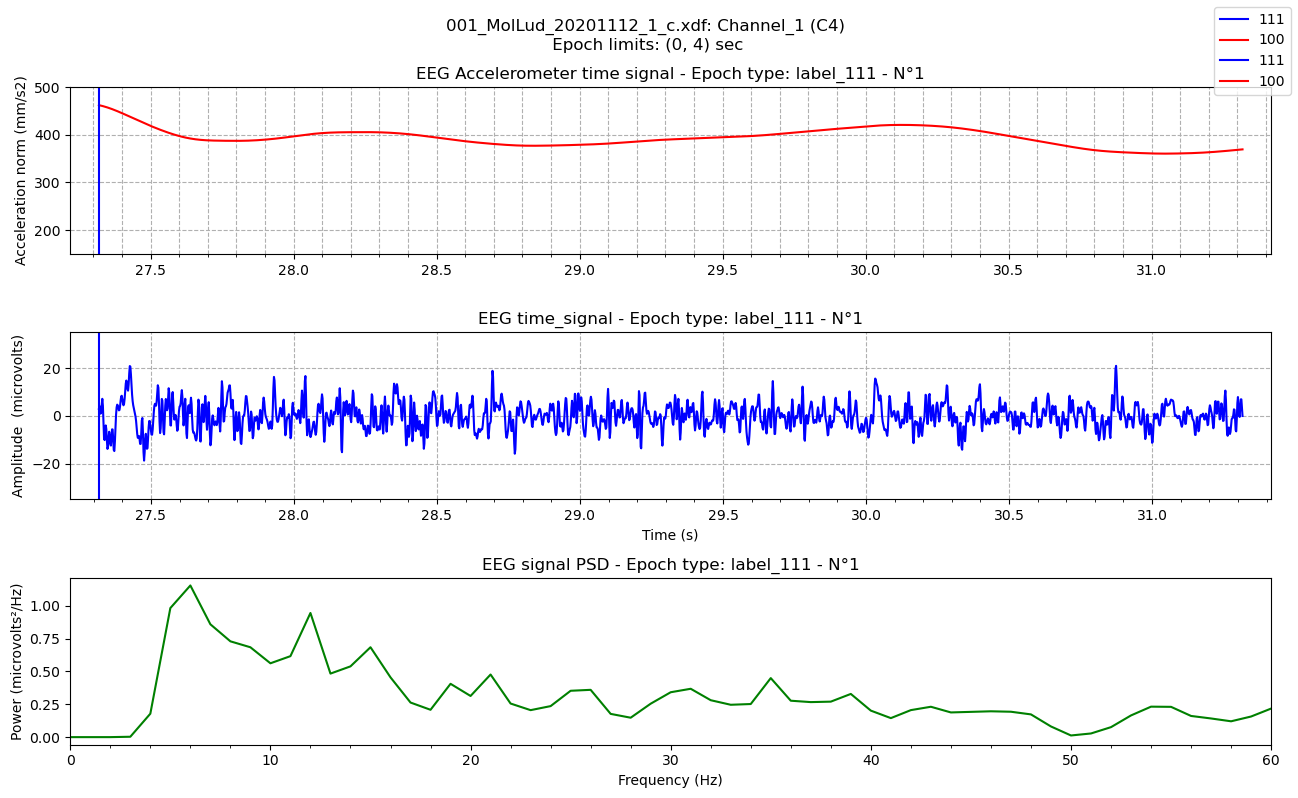

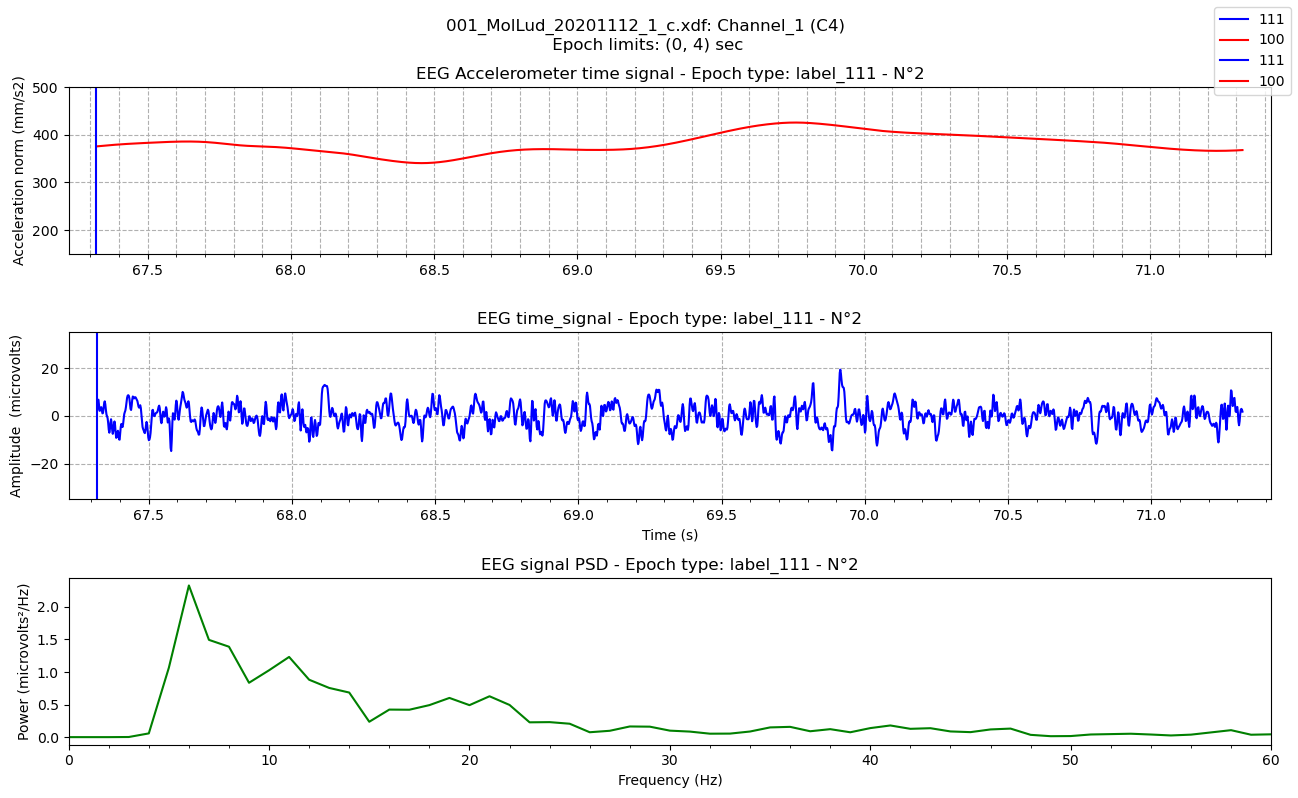

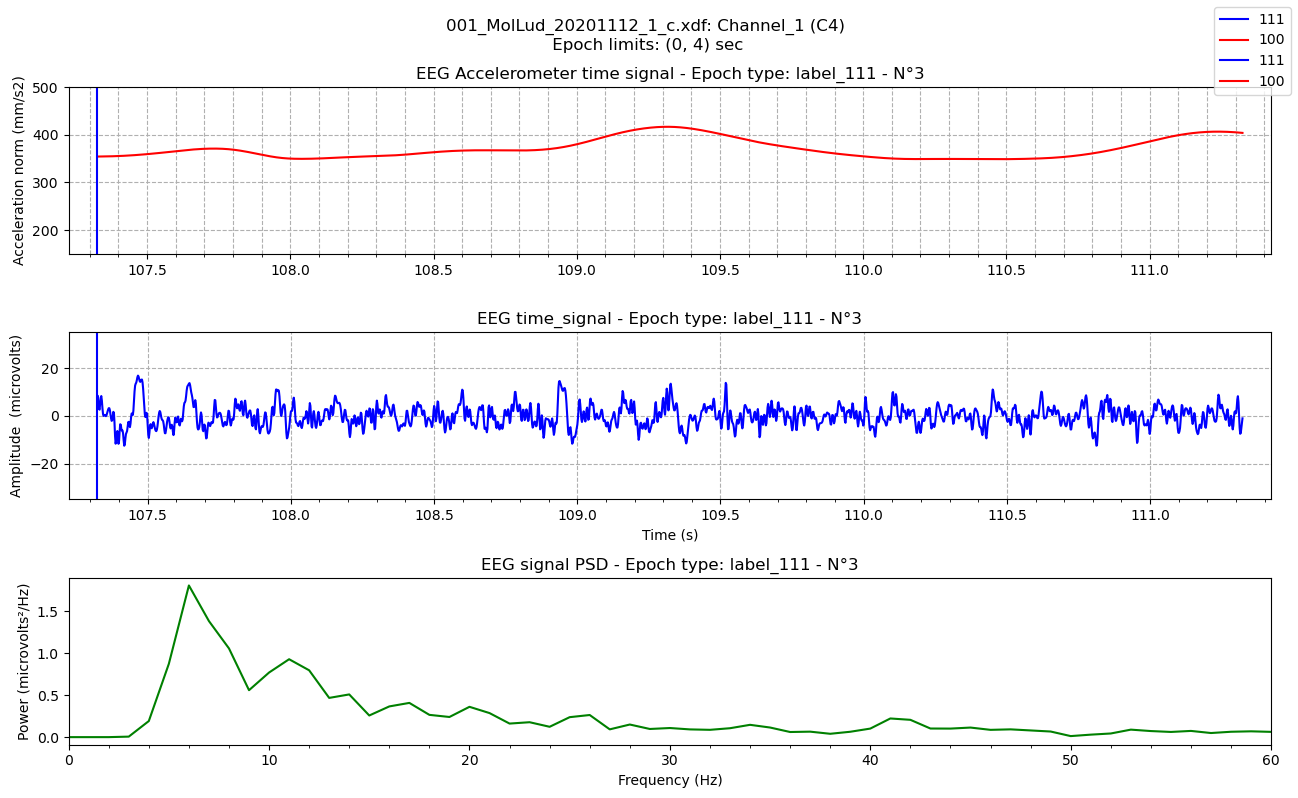

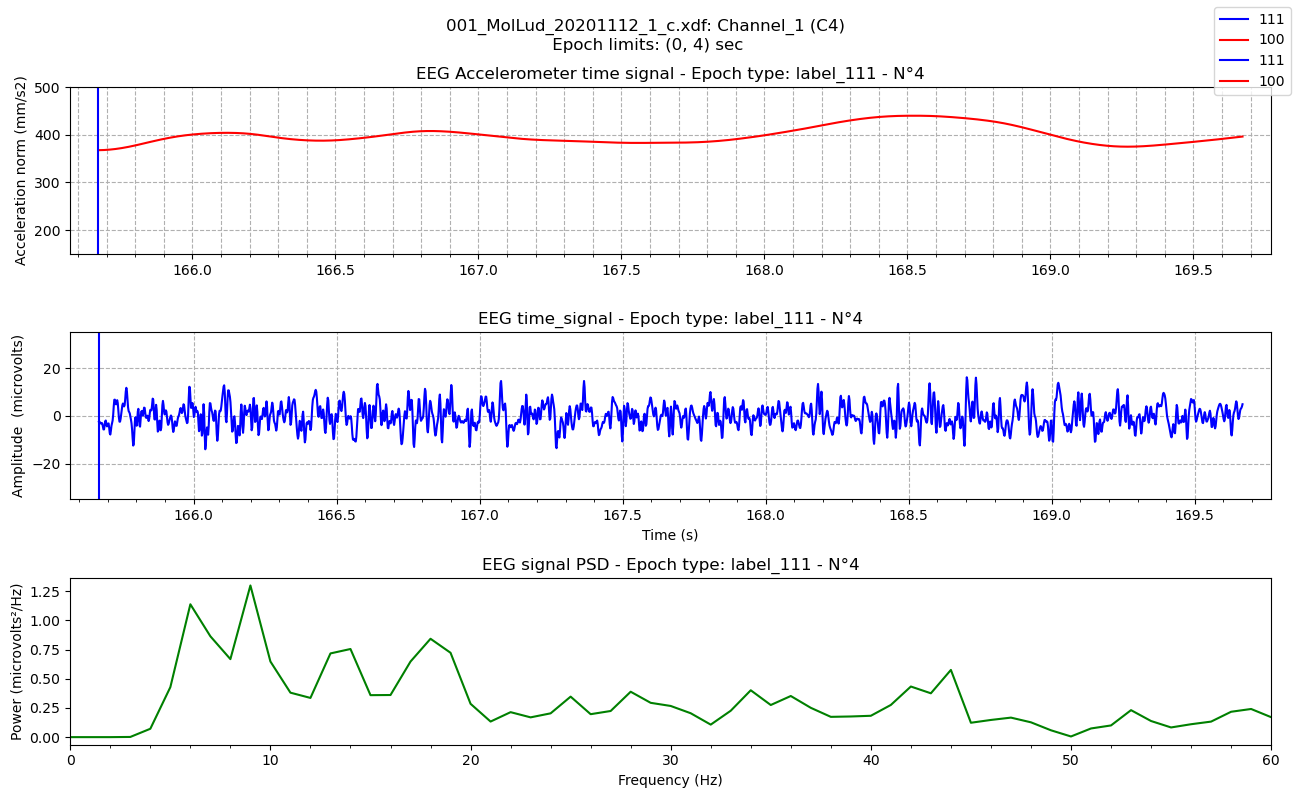

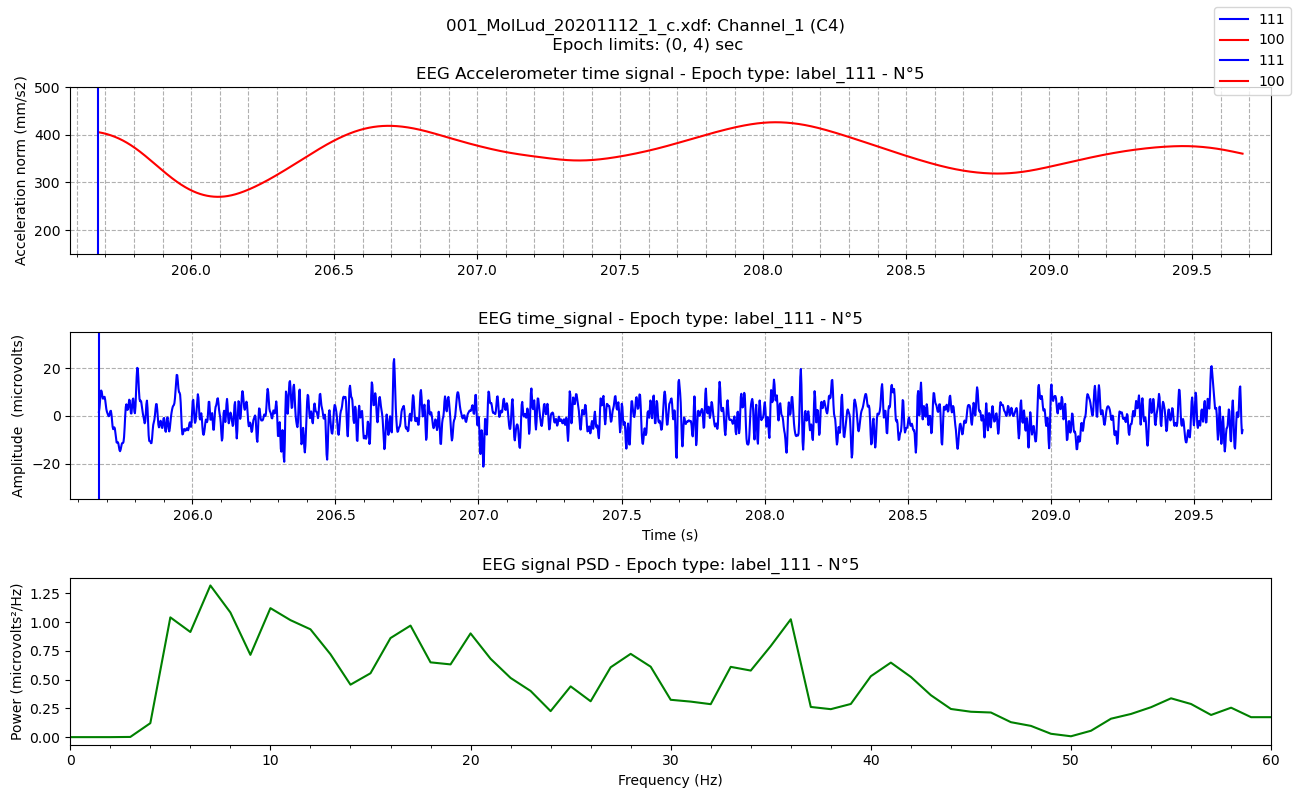

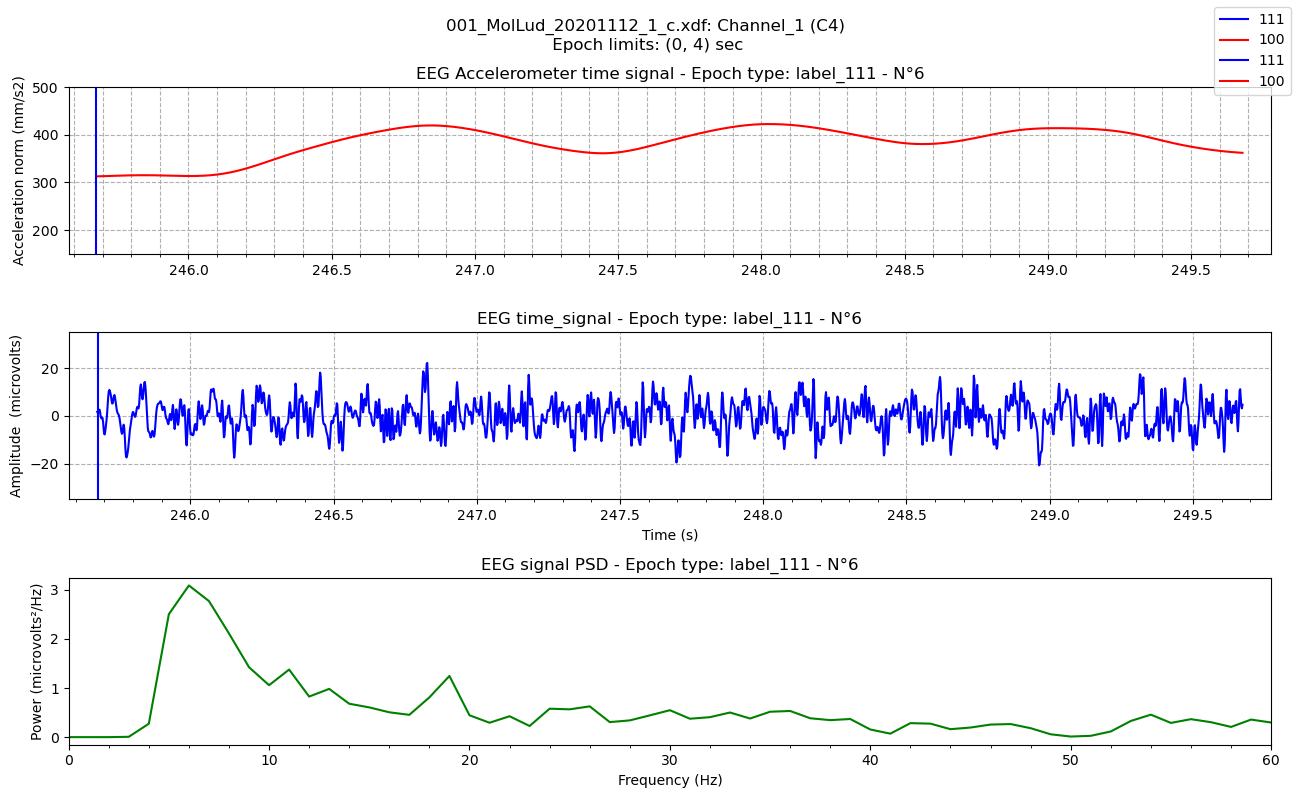

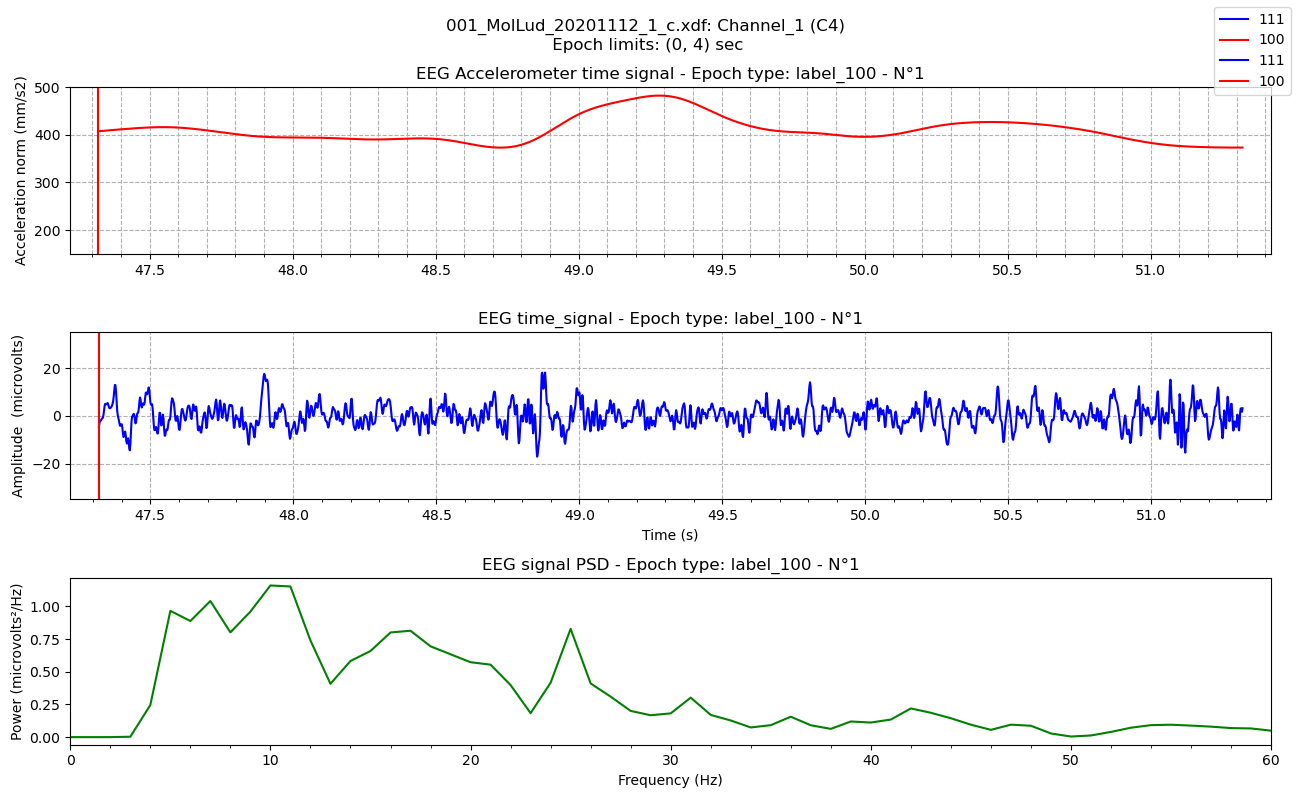

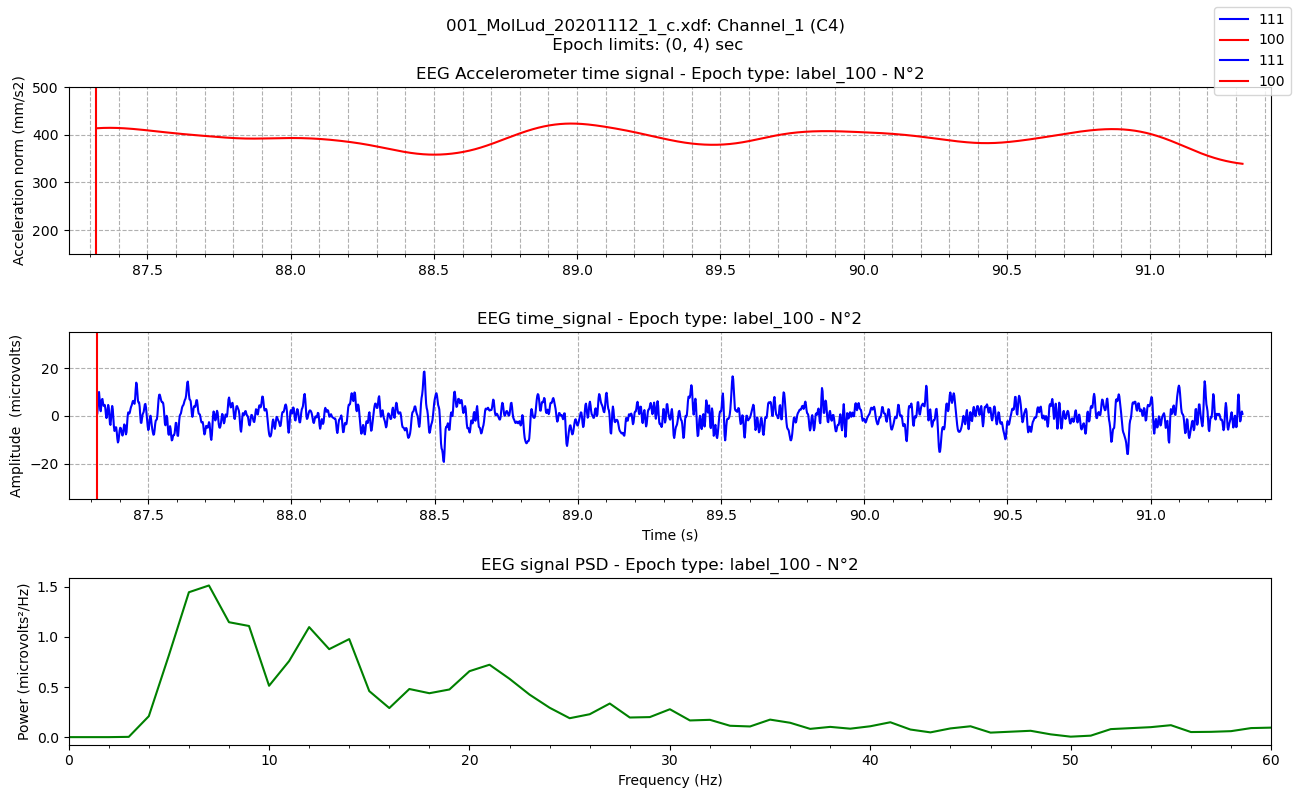

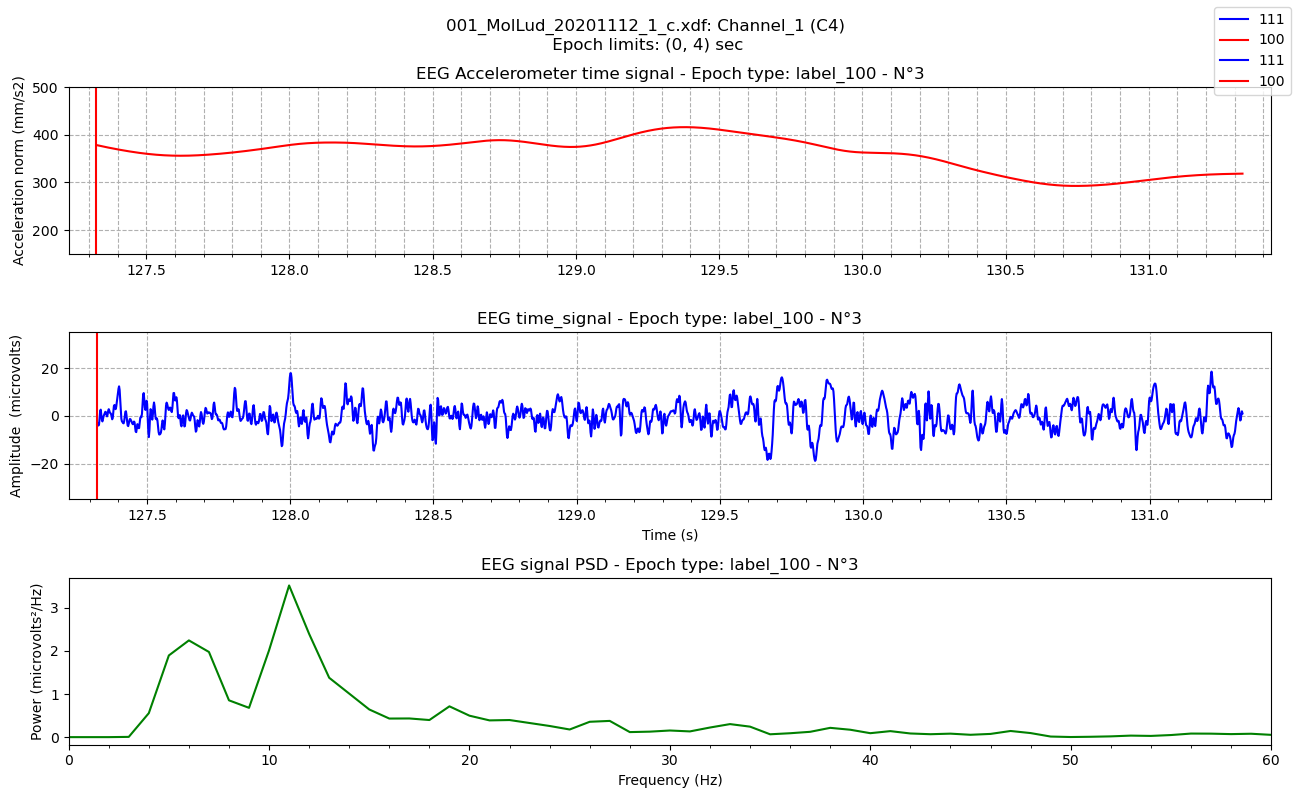

In [57]:
import matplotlib.ticker as ticker

figures_channels_dict = {}

for electrode_index in range(EEG_data["data"]["time_series"].shape[1]):
    channel_num = electrode_index+1
    channel_id = f"Channel_{channel_num}"
    channel_name = channels_dict[channel_id]

    figures_channel_dict = {}
    for marker_type in eeg_accelerometer_norm_filtered_epoched.keys():

        figures_epochs_list = []

        for epoch_index in range(EEG_signals_epochs_psds["Channel_1"]["Epochs"]["time_signals"]["label_100"]["time_segments"].shape[1]):

            epoch_num = epoch_index+1

            liste = [eeg_accelerometer_norm_filtered_epoched[marker_type]["time_segments"][:, epoch_index],
                     eeg_accelerometer_norm_filtered_epoched[marker_type]["signal_segments"][:, epoch_index],
                     EEG_signals_epochs_psds[channel_id]["Epochs"]["time_signals"][marker_type]["time_segments"][:, epoch_index],
                     EEG_signals_epochs_psds[channel_id]["Epochs"]["time_signals"][marker_type]["signal_segments"][:, epoch_index],
                     EEG_signals_epochs_psds[channel_id]["Epochs"]["PSDs"][marker_type]["PSD_frequencies"][:, epoch_index],
                     EEG_signals_epochs_psds[channel_id]["Epochs"]["PSDs"][marker_type]["PSD_magnitudes"][:, epoch_index]]

            # plot the results
            figure, axis = plt.subplots(3, figsize=(13, 8))
            figure.suptitle(
                f"{xdf_input_filename}: {channel_id} ({channel_name})\n Epoch limits: {epoch_limits} sec")

            axis[0].set_title(
                f"EEG Accelerometer time signal - Epoch type: {marker_type} - N°{epoch_num}")
            axis[0].set_ylabel(
                f"Acceleration norm ({eeg_accelerometer_units})")

            axis[0].plot(liste[0], liste[1], color="red")
            show_markers2(
                plot_type=axis[0], markers_times_array=mouse_marker_times_labels)

            axis[0].set_xlim(liste[0][0]-0.1, liste[0][-1]+0.1)
            axis[0].set_ylim(150, 500)
            axis[0].xaxis.set_minor_locator(ticker.AutoMinorLocator())
            axis[0].grid(which="both", axis="both", linestyle="--")

            axis[1].set_title(
                f"EEG time_signal - Epoch type: {marker_type} - N°{epoch_num}")
            axis[1].set_ylabel(f"Amplitude  ({EEG_units})")
            axis[1].set_xlabel(f"Time (s)")
            axis[1].plot(liste[2], liste[3], color="blue")
            show_markers2(
                plot_type=axis[1], markers_times_array=mouse_marker_times_labels)

            axis[1].set_xlim(liste[2][0]-0.1, liste[2][-1]+0.1)
            axis[1].set_ylim(-35, 35)
            axis[1].xaxis.set_minor_locator(ticker.AutoMinorLocator())
            axis[1].grid(which="major", axis="both", linestyle="--")

            axis[2].set_title(
                f"EEG signal PSD - Epoch type: {marker_type} - N°{epoch_num}")
            axis[2].set_ylabel(f"Power ({EEG_units}²/Hz)")
            axis[2].set_xlabel(f"Frequency (Hz)")
            axis[2].plot(liste[4], liste[5], color="green")

            axis[2].set_xlim(0, 60)

            axis[2].xaxis.set_minor_locator(ticker.AutoMinorLocator())

            figure.set_tight_layout(True)
            figure.legend()
            figures_epochs_list.append(figure)
        figures_channel_dict[marker_type] = figures_epochs_list
    figures_channels_dict[channel_id] = figures_channel_dict

In [ ]:
figures_channels_list = []
# figures of each type should alternate to follow chronological order
for channel_i in figures_channels_dict.keys():
    electrode_i = merge_lists_alternatively(
        figures_channels_dict[channel_i]["label_111"], figures_channels_dict[channel_i]["label_100"])
    # electrode_i=merge_alternatively(figures_channels_dict[key]["group_111"],figures_channels_dict[key]["group_100"])
    figures_channels_list.append(electrode_i)

nestedlist = figures_channels_list
flatlist = []

for sublist in nestedlist:
    for element in sublist:
        flatlist.append(element)

print(len(flatlist))

96


#### export plots to PDF

In [ ]:
save_figures_to_pdf_single_per_page(pdf_filename="all_electrodes_soloV2.pdf", figures_list=flatlist)

In [ ]:
save_figures_to_pdf_multiple_per_page(figures=flatlist, filename="all_electrodes_blocksV2.pdf", rows_per_page=6)